# A simple example of lensing estimator modules
This code compute normalization and power spectrum of quadratic estiamtors

In [1]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl

First define parameters

In [2]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, 2048  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [3]:
# ucl is an array of shape [0:5,0:rlmax+1] and ucl[0,:] = TT, ucl[1,:] = EE, ucl[2,:] = TE, lcl[3,:] = phiphi, lcl[4,:] = Tphi
ucl = basic.aps.read_cambcls('../data/unlensedcls.dat',2,rlmax,5)/Tcmb**2 # TT, EE, TE, pp, Tp
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,rlmax,4,bb=True)/Tcmb**2 # TT, EE, BB, TE

Define observed CMB cls. Here, no CMB noise.

In [4]:
ocl = lcl # observed Cl (here, no CMB noise)

### Compute normalization

QDO below specifies which normalizations will be computed: TT, TE, EE, TB, EB, BB (currently BB is ignored even if you set True)

MV is also automatically computed from these specified estimators

In [5]:
QDO = [True,True,True,True,True,False] # this means that TT, TE, EE, TB and EB are used for MV estimator

"Wg" ("Wc") below is the optimal weight for constructing the MV estimator; $$\phi^{MV} = A^{MV}\sum_q W_q \phi^q$$ where $W$ is Wg (Wc) and $q = TT, TE, \dots$. 
BB is not output, and the array has 6 normalizations (TT, TE, EE, TB, EB and MV)

In [6]:
Ag, Ac, Wg, Wc = cs.norm_lens.qall(QDO,Lmax,rlmin,rlmax,lcl,ocl)

Alternatively, normalization is also computed from the following functions: 

In [7]:
#Ag, Ac = {}, {}
#Ag['TT'], Ac['TT'] = cs.norm_lens.qtt(Lmax,rlmin,rlmax,lcl[0,:],lcl[0,:])
#Ag['TE'], Ac['TE'] = cs.norm_lens.qte(Lmax,rlmin,rlmax,lcl[3,:],lcl[0,:],lcl[1,:])
#Ag['EE'], Ac['EE'] = cs.norm_lens.qee(Lmax,rlmin,rlmax,lcl[1,:],lcl[1,:])
#Ag['TB'], Ac['TB'] = cs.norm_lens.qtb(Lmax,rlmin,rlmax,lcl[3,:],lcl[0,:],lcl[2,:])
#Ag['EB'], Ac['EB'] = cs.norm_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],lcl[1,:],lcl[2,:])

The results of normalization calculation are as follows for gradient adn curl modes

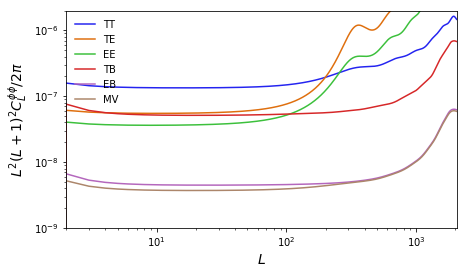

In [8]:
# plot normalization (gradient)
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,xlog=True,ymin=1e-9,ymax=2e-6,ylog=True,ylab=r'$L^2(L+1)^2C^{\phi\phi}_L/2\pi$')
for qi, q in enumerate(['TT','TE','EE','TB','EB','MV']):
    plot(L,Lfac*Ag[qi,:],label=q)
legend()

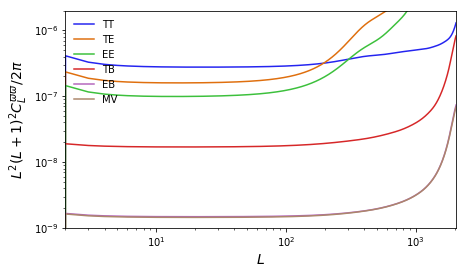

In [9]:
# plot normalization (curl)
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,xlog=True,ymin=1e-9,ymax=2e-6,ylog=True,ylab=r'$L^2(L+1)^2C^{\varpi\varpi}_L/2\pi$')
for qi, q in enumerate(['TT','TE','EE','TB','EB','MV']):
    plot(L,Lfac*Ac[qi,:],label=q)
legend()

In [10]:
# Output reconstructed estimator spectra (if necessary)
#np.savetxt('al.dat',np.concatenate((L[None,:],Ag,Ac)).T,fmt='%4.6e')
#np.savetxt('nl.dat',np.concatenate((L[None,:],nlg,nlc)).T,fmt='%4.6e')

### Comparison with a simple simulation

Generate CMB alms - to measure lensing cl, you need Talm, Ealm and Balm from a lensed cmb simulation

In [11]:
Talm, Ealm, Balm = cs.utils.gaussTEB(rlmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])

Then apply diagonal C-inverse filtering (idealistic case)

In [12]:
Fl = np.zeros((3,rlmax+1,rlmax+1)) # the first index means 0=T, 1=E, 2=B
for l in range(rlmin,rlmax+1):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [13]:
# multiply filter to alms
Talm *= Fl[0,:,:]
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

Compute unnormalized estiamtors

In [14]:
glm, clm = {}, {}
glm['TT'], clm['TT'] = cs.rec_lens.qtt(Lmax,rlmin,rlmax,lcl[0,:],Talm,Talm)
glm['TE'], clm['TE'] = cs.rec_lens.qte(Lmax,rlmin,rlmax,lcl[3,:],Talm,Ealm)
glm['EE'], clm['EE'] = cs.rec_lens.qee(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Ealm)
glm['TB'], clm['TB'] = cs.rec_lens.qtb(Lmax,rlmin,rlmax,lcl[3,:],Talm,Balm)
glm['EB'], clm['EB'] = cs.rec_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)

Normalize estimators using normalization computed above

In [15]:
for qi, q in enumerate(['TT','TE','EE','TB','EB']):
    glm[q] *= Ag[qi,:,None]
    clm[q] *= Ac[qi,:,None]

Construct MV estimator

In [16]:
glm['MV'], clm['MV'] = 0., 0.
for qi, q in enumerate(['TT','TE','EE','TB','EB']):
    glm['MV'] += Wg[qi,:,None]*glm[q]
    clm['MV'] += Wc[qi,:,None]*clm[q]
glm['MV'] *= Ag[5,:,None]
clm['MV'] *= Ac[5,:,None]

Compute power spectrum of the reconstructed estimators

In [17]:
gg, cc = {}, {}
for q in ['TT','TE','EE','TB','EB','MV']:
    gg[q] = cs.utils.alm2cl(Lmax,glm[q])
    cc[q] = cs.utils.alm2cl(Lmax,clm[q])

The quadratic estimator power spectra should be equivalent to the normalization for Gaussian fluctuations 

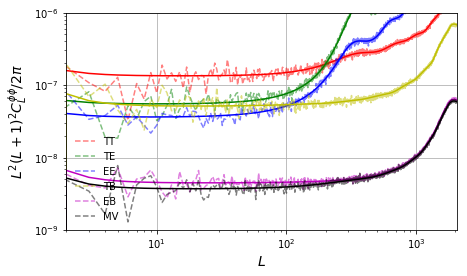

In [18]:
# plot spectra (gradient)
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,xlog=True,ylog=True,ymin=1e-9,ymax=1e-6,grid=True,ylab=r'$L^2(L+1)^2C^{\phi\phi}_L/2\pi$')
for qi, (c, q) in enumerate([('r','TT'),('g','TE'),('b','EE'),('y','TB'),('m','EB'),('k','MV')]):
    plot(L,Lfac*gg[q],color=c,ls='--',label=q,alpha=.5)
    plot(L,Lfac*Ag[qi,:],color=c,ls='-')
legend()

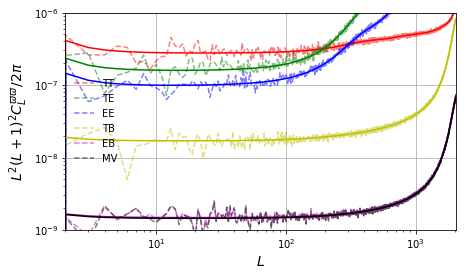

In [19]:
# plot spectra (curl)
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,xlog=True,ylog=True,ymin=1e-9,ymax=1e-6,grid=True,ylab=r'$L^2(L+1)^2C^{\varpi\varpi}_L/2\pi$')
for qi, (c, q) in enumerate([('r','TT'),('g','TE'),('b','EE'),('y','TB'),('m','EB'),('k','MV')]):
    plot(L,Lfac*cc[q],color=c,ls='--',label=q,alpha=.5)
    plot(L,Lfac*Ac[qi,:],color=c,ls='-')
legend()